In [1]:
from abc import ABC, abstractmethod
from dataclasses import dataclass
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
DEBUG = False

# Definitions and Helper Functions

In [3]:
def create_dirpath(path):
    dirpath = os.path.dirname(path)
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [4]:
# Define a typical Prisoner's Dilemma payoff matrix
TYPICAL_PAYOFF_MATRIX = {
    "C": {"C": (3, 3), "D": (0, 5)},
    "D": {"C": (5, 0), "D": (1, 1)},
}

NEGATIVE_PAYOFF_MATRIX = {
    "C": {"C": ( 5,  5), "D": (-2, 12)},
    "D": {"C": (12, -2), "D": ( 0,  0)},
}

PAYOFF_MATRIX_FOR_ADAPTIVE = {
    "C": {"C": (5, 5), "D": (-2, 3)},
    "D": {"C": (3, -2), "D": (1, 1)},
}

# Strategies

In [5]:
# Abstract Class for Strategy.
class Strategy(ABC):
    @abstractmethod
    def move(self, own_history):
        pass

In [6]:
class ListRepeatedStrategy(Strategy):
    def __init__(self, moves=["C", "C", "D"]):
        self.moves = moves
        self.current_index = 0

    def move(self, own_history):
        move = self.moves[self.current_index]
        self.current_index = (self.current_index + 1) % len(self.moves)
        return move

In [7]:
# Naively faithful player (always chooses C)
class AlwaysCooperateStrategy(Strategy):
    def move(self, own_history):
        move = "C"
        return move

In [8]:
# Always chooses D
class AlwaysDefectStrategy(Strategy):
    def move(self, own_history):
        move = "D"
        return move

In [9]:
# Alternating choices between C and D
class AlternatingStrategy(Strategy):
    def move(self, own_history):
        if not own_history or own_history[-1] == "D":
            move = "C"
        else:
            move = "D"
        return move

In [10]:
class RandomStrategy(Strategy):
    def move(self, own_history):
        move = random.choice(["C", "D"])
        return move

In [11]:
class DeadStrategy(Strategy):
    def move(self, own_history):
        return None

# Strategy Switchers

In [12]:
class StrategySwitcher(ABC):
    def __init__(self, **kwargs):
        pass

    @abstractmethod
    def check(self, agent, opponent):
        pass

In [13]:
class NOPSwitcher(StrategySwitcher):
    def check(self, agent, opponent):
        return False, None

In [14]:
# class UseMostCommonNeighborStrategy(StrategySwitcher):
#     def check(self, agent, opponent):
#         neighbor_strategies = [
#             neighbor.strategy.__class__ for neighbor in agent.neighbors
#         ]

#         strategy_counts = {}
#         for strategy in neighbor_strategies:
#             strategy_counts[strategy] = strategy_counts.get(strategy, 0) + 1

#         most_frequent_strategy = max(strategy_counts, key=strategy_counts.get)

#         if DEBUG:
#             print("Whole list: ", neighbor_strategies)
#             print("Most frequent: ", most_frequent_strategy)

#         # Dynamically instantiate the class based on the most frequent string
#         try:
#             return True, most_frequent_strategy()
#         except NameError:
#             print("Something wrong with my neighbors!")
#             return False, None

In [15]:
class SoftMajor(StrategySwitcher):
    def check(self, agent, opponent, threshold=0.5):
        assert agent.strategy.__class__.__name__ in [
            "AlwaysCooperateStrategy",
            "AlwaysDefectStrategy",
        ]
        opponent_tally = agent.gather_opponent_tally(opponent)
        opponent_cooperation_rate = opponent_tally.get_cooperation_rate()

        if opponent_cooperation_rate > threshold and agent.strategy.__class__.__name__ != "AlwaysCooperateStrategy":
            return True, AlwaysCooperateStrategy()
        elif opponent_cooperation_rate < threshold and agent.strategy.__class__.__name__ != "AlwaysDefectStrategy":
            return True, AlwaysDefectStrategy()
        return False, None

In [16]:
class AdaptiveSwitcher(StrategySwitcher):
    def __init__(self, payoff_matrix, **kwargs):
        self.payoff_matrix = payoff_matrix
        super().__init__(**kwargs)

    def check(self, agent, opponent):
        assert agent.strategy.__class__.__name__ in [
            "AlwaysCooperateStrategy",
            "AlwaysDefectStrategy",
        ]
        opponent_tally = agent.gather_opponent_tally(opponent)
        opponent_cooperation_rate = opponent_tally.get_cooperation_rate()

        reward_C = opponent_cooperation_rate * self.payoff_matrix["C"]["C"][0] + (1 - opponent_cooperation_rate) * self.payoff_matrix["C"]["D"][0]
        reward_D = opponent_cooperation_rate * self.payoff_matrix["D"]["C"][0] + (1 - opponent_cooperation_rate) * self.payoff_matrix["D"]["D"][0]

        if reward_C > reward_D and agent.strategy.__class__.__name__ != "AlwaysCooperateStrategy":
            return True, AlwaysCooperateStrategy()
        elif reward_C < reward_D and agent.strategy.__class__.__name__ != "AlwaysDefectStrategy":
            return True, AlwaysDefectStrategy()

        return False, None

In [17]:
class RandomSwitcher(StrategySwitcher):
    def __init__(self, **kwargs):
        self.pool_of_strats = Strategy.__subclasses__()
        self.pool_of_strats.remove(DeadStrategy)
        super().__init__(**kwargs)

    def check(self, agent, opponent):
        return True, random.choice(self.pool_of_strats)()

In [18]:
class TitForTat(StrategySwitcher):
    def check(self, agent, opponent):
        # opponent_history = opponent.history
        opponent_history = agent.neighbor_histories[opponent.id]
        if DEBUG:
            print(
                f"Agent {agent.id} has strategy {agent.strategy.__class__.__name__} and switcher {self.__class__.__name__}"
            )
        assert agent.strategy.__class__.__name__ in [
            "AlwaysCooperateStrategy",
            "AlwaysDefectStrategy",
        ]

        if (
            opponent_history
            and opponent_history[-1] == "D"
            and agent.strategy.__class__.__name__ == "AlwaysCooperateStrategy"
        ):
            return True, AlwaysDefectStrategy()
        elif (
            opponent_history
            and opponent_history[-1] == "C"
            and agent.strategy.__class__.__name__ == "AlwaysDefectStrategy"
        ):
            return True, AlwaysCooperateStrategy()

        return False, None

In [19]:
class CooperateUntilNDefectionsInARow(StrategySwitcher):
    def __init__(self, n_defections_threshold=2, **kwargs):
        if DEBUG:
            print(f"Initting CooperateUntilNDefectionsInARow with {n_defections_threshold}")
        self.n_defections_threshold = n_defections_threshold
        self.n_defections_in_a_row = 0
        self.threshold_hit = False
        super().__init__(**kwargs)

    def check(self, agent, opponent):
        opponent_history = agent.neighbor_histories[opponent.id]
        if DEBUG:
            print(f"CooperateUntilNDefections: Checking if should switch for agent {agent.id}")
            print(f"\tGot opponent history {opponent_history}")

        assert agent.strategy.__class__.__name__ in [
            "AlwaysCooperateStrategy",
            "AlwaysDefectStrategy",
        ]
        assert self.n_defections_in_a_row >= 0

        if opponent_history and opponent_history[-1] == "D":
            if DEBUG:
                print("Increasing defections in a row")
            self.n_defections_in_a_row += 1
        else:
            self.n_defections_in_a_row = 0

        if DEBUG:
            print(
                f"Have seen {self.n_defections_in_a_row} defections in a row. Threshold is {self.n_defections_threshold}"
            )
        if not self.threshold_hit and self.n_defections_in_a_row >= self.n_defections_threshold:
            if DEBUG:
                print("Threshold hit!")
            self.threshold_hit = True

        if agent.strategy.__class__.__name__ == "AlwaysCooperateStrategy" and self.threshold_hit:
            if DEBUG:
                print("Switching to AlwaysDefect")
            return True, AlwaysDefectStrategy()

        return False, None

In [20]:
class RetaliateWithTwoDefections(StrategySwitcher):
    def __init__(self, **kwargs):
        self.retaliations_left = 0
        super().__init__(**kwargs)

    def check(self, agent, opponent):
        # opponent_history = opponent.history
        opponent_history = agent.neighbor_histories[opponent.id]

        assert agent.strategy.__class__.__name__ in [
            "AlwaysCooperateStrategy",
            "AlwaysDefectStrategy",
        ]
        assert self.retaliations_left >= 0

        if self.retaliations_left > 0:
            self.retaliations_left -= 1

        if opponent_history and opponent_history[-1] == "D":
            self.retaliations_left += 2

        if self.retaliations_left > 0 and agent.strategy.__class__.__name__ == "AlwaysCooperateStrategy":
            return True, AlwaysDefectStrategy()
        elif self.retaliations_left == 0 and agent.strategy.__class__.__name__ == "AlwaysDefectStrategy":
            return True, AlwaysCooperateStrategy()

        return False, None

# Player

In [21]:
@dataclass
class PlayerMoveTally:
    cooperations: int = 0
    defections: int = 0

    def update(self, move):
        if move == "C":
            self.cooperations += 1
        elif move == "D":
            self.defections += 1
        else:
            raise ValueError(f"Move must be either 'C' or 'D', got {move}")

    def get_cooperation_rate(self):
        # Assume the best in people
        if self.cooperations + self.defections == 0:
            return 1

        return self.cooperations / (self.cooperations + self.defections)

    def __add__(self, other):
        return PlayerMoveTally(
            cooperations=self.cooperations + other.cooperations,
            defections=self.defections + other.defections,
        )

    def __str__(self):
        return f"Cooperations: {self.cooperations}, Defections: {self.defections}"

In [22]:
# Generic class for any Player (next block we shall define inherited classes with specific strategies)
class Player:
    def __init__(self, strategy, strategy_switcher, credit=0, neighbors=[]):
        self.history = []
        self.strategy = strategy
        self.strategy_switcher = strategy_switcher
        self.neighbors = []
        self.neighbor_tallies = {}
        self.neighbor_histories = {}
        self.credit = credit

        self.add_neighbors(neighbors)

    def add_neighbors(self, neighbors):
        assert isinstance(neighbors, list), f"Expected a list of neighbors, got {type(neighbors)}"

        for neighbor in neighbors:
            if neighbor not in self.neighbors:
                self.neighbors.append(neighbor)
                self.neighbor_tallies[neighbor.id] = PlayerMoveTally()
                self.neighbor_histories[neighbor.id] = []

    def set_credit(self, credit):
        self.credit = credit

    def gather_opponent_tally(self, opponent):
        opponent_tally = self.neighbor_tallies.get(opponent.id, PlayerMoveTally())

        if DEBUG:
            print(f"Player {self.id} gathering opponent tally for {opponent.id}")
            print(f"Knows '{opponent_tally}' so far")

        for neighbor in self.neighbors:
            if neighbor.id == opponent.id:
                continue

            neighbor_info = neighbor.neighbor_tallies.get(opponent.id, PlayerMoveTally())
            opponent_tally += neighbor_info

            if DEBUG:
                print(f"\tGot '{neighbor_info}' from {neighbor.id}")
                print(f"\tUpdated tally to '{opponent_tally}'")

        return opponent_tally

    def update_tally(self, opponent, opponent_move):
        self.neighbor_tallies[opponent.id].update(opponent_move)
        self.neighbor_histories[opponent.id].append(opponent_move)

    def check_should_switch_strategy(self, opponent):
        should_switch_strategy, next_strategy = self.strategy_switcher.check(self, opponent)
        if should_switch_strategy:
            if DEBUG:
                print(f"Agent {self.id} switching strategy to {next_strategy.__class__.__name__}")
            self._switch_strategy(next_strategy)

    def play(self, opponent):
        decision = self.strategy.move(self.history)
        self.update_history(decision)
        return decision

    def update_history(self, own_move):
        self.history.append(own_move)

    def update_credit(self, addend):
        self.credit += addend
        if DEBUG:
            print(f"Agent {self.id} credit is now {self.credit}")
        if self.is_dead():
            self.strategy = DeadStrategy()

    def is_dead(self):
        result = self.credit < 0
        if DEBUG:
            print(f"Agent {self.id} is dead: {result}")
        return result

    def check_credit(self):
        return self.credit

    def latest_move(self):
        return self.history[-1]

    def _switch_strategy(self, new_strategy):
        self.strategy = new_strategy
        if DEBUG:
            print(f"Agent {self.id} now has switched to strategy {self.strategy.__class__.__name__}")

# Network Generator

In [23]:
@dataclass
class Edge:
    x1: int
    y1: int
    x2: int
    y2: int

    @classmethod
    def from_indices(cls, index1, index2, width):
        x1, y1 = index1 // width, index1 % width
        x2, y2 = index2 // width, index2 % width
        return cls(x1, y1, x2, y2)

    def __str__(self):
        return f"({self.x1}, {self.y1}) -> ({self.x2}, {self.y2})"

In [24]:
@dataclass
class NetworkPosition:
    x: int
    y: int

    @classmethod
    def from_index(cls, index, width):
        return cls(index // width, index % width)

    def to_index(self, width):
        return self.x * width + self.y

    def __str__(self):
        return f"({self.x}, {self.y})"

In [25]:
class Network:
    def __init__(self, N, M, Ntype="Lattice", density=0, spread=0):
        assert Ntype in ["Graph", "Lattice", "CLattice"]
        self.dim = (N, M)
        self.sz = N * M
        self.type = Ntype
        self.density = density
        self.spread = spread

    def generate(self):
        self.l = [[0 for _ in range(self.sz)] for _ in range(self.sz)]
        self.edges = []

        if self.type == "Graph":
            e = int((self.sz * self.sz - self.sz) * self.density / 2)
            assert e > 0

            random.seed(int(self.sz * e / 4))

            cnt = 0
            while cnt < e:
                edj = random.randrange(0, self.sz * self.sz)
                u, v = edj % self.sz, edj // self.sz
                if u == v or self.l[u][v] > 0:
                    continue
                self.l[u][v] = self.l[v][u] = 1
                cnt = cnt + 1

        elif self.type == "Lattice":
            for i in range(0, self.dim[0]):
                for j in range(0, self.dim[1]):
                    if i > 0:
                        self.l[i * self.dim[1] + j][(i - 1) * self.dim[1] + j] = 1
                    if i < self.dim[0] - 1:
                        self.l[i * self.dim[1] + j][(i + 1) * self.dim[1] + j] = 1
                    if j > 0:
                        self.l[i * self.dim[1] + j][i * self.dim[1] + j - 1] = 1
                    if j < self.dim[1] - 1:
                        self.l[i * self.dim[1] + j][i * self.dim[1] + j + 1] = 1

        elif self.type == "CLattice":
            for i in range(0, self.dim[0]):
                for j in range(0, self.dim[1]):
                    if i > 0:
                        self.l[i * self.dim[1] + j][(i - 1) * self.dim[1] + j] = 1
                    if i < self.dim[0] - 1:
                        self.l[i * self.dim[1] + j][(i + 1) * self.dim[1] + j] = 1
                    if j > 0:
                        self.l[i * self.dim[1] + j][i * self.dim[1] + j - 1] = 1
                    if j < self.dim[1] - 1:
                        self.l[i * self.dim[1] + j][i * self.dim[1] + j + 1] = 1

            e = int((self.sz * self.sz - self.sz) * self.density / 2)
            assert e > 0

            random.seed(int(self.sz * e / 4))

            cnt = 0
            while cnt < e:
                edj1 = random.randrange(0, self.sz)
                u1, v1 = edj1 // self.dim[1], edj1 % self.dim[1]
                u2, v2 = round(random.gauss(u1, self.spread)), round(random.gauss(v1, self.spread))
                if (u1 == u2 and v1 == v2) or u2 < 0 or u2 >= self.dim[0] or v2 < 0 or v2 >= self.dim[1]:
                    continue
                edj2 = u2 * self.dim[1] + v2
                if self.l[edj1][edj2] > 0:
                    continue
                self.l[edj1][edj2] = self.l[edj2][edj1] = 1
                cnt = cnt + 1

        for i in range(self.sz):
            for j in range(i + 1, self.sz):
                if self.l[i][j]:
                    self.edges.append(Edge.from_indices(i, j, self.dim[1]))

        self.E = len(self.edges)

    def getEdges(self, from_position):
        eList = []
        for v in range(0, self.sz):
            if self.l[from_position.to_index(self.dim[1])][v] == 1:
                eList.append(NetworkPosition.from_index(v, self.dim[1]))

        return eList

    def printNet(self):
        print("|V| = " + str(self.sz) + "; |E| = " + str(self.E))
        for u in range(self.sz):
            at = NetworkPosition.from_index(u, self.dim[1])
            print(f"{at}: ", end="")
            lst = self.getEdges(at)
            for network_position in lst:
                print(f" {network_position}", end="")
            print()

In [26]:
net1 = Network(5, 5, "Lattice")
net1.generate()
# net1.printNet()
assert net1.E == 40

In [27]:
net2 = Network(5, 5, "Graph", density=0.25)
net2.generate()
# net2.printNet()
assert net2.E == 75

In [28]:
net3 = Network(5, 5, "CLattice", density=0.04, spread=5)
net3.generate()
# net3.printNet()
assert net3.E == 52

# Simulator

In [29]:
class SimulatorPlayer(Player):
    next_id = 0

    def __init__(self):
        self.id = SimulatorPlayer.next_id
        SimulatorPlayer.next_id += 1
        super().__init__(None, None)

    def init(self, neighbors, player):
        if DEBUG:
            print(f"Initializing player {self.id}")

        self.add_neighbors(neighbors)
        self.history = player.history
        self.strategy = player.strategy
        self.strategy_switcher = player.strategy_switcher
        self.set_credit(player.credit)

    def play(self, opponent):
        return super().play(opponent)

In [30]:
import copy


class Simulator:
    def __init__(self, n, m, pm):
        self.n = n
        self.m = m
        self.payoff_matrix = pm
        self.population = []
        self.cooperation_percentage = []
        self.status_matrix = [
            [False for _ in range(m)] for _ in range(n)
        ]  # to store if self.grid[i,j] is dead or alive

    def init_network(self, ntype="Lattice", density=0.0, spread=0.0):
        self.network = Network(self.n, self.m, ntype, density, spread)
        self.network.generate()

    def init_grid(self):
        self.grid = []
        for i in range(self.n):
            self.grid.append([])
            for j in range(self.m):
                self.grid[i].append(SimulatorPlayer())
        self.pairs = [(self.grid[edge.x1][edge.y1], self.grid[edge.x2][edge.y2]) for edge in self.network.edges]

    def set_player(self, i, j, player):
        ngbr_list = self.network.getEdges(NetworkPosition(i, j))
        ngbrs = [self.grid[network_position.x][network_position.y] for network_position in ngbr_list]
        self.grid[i][j].init(ngbrs, player)

    def match(self, p1: SimulatorPlayer, p2: SimulatorPlayer):
        if p1.is_dead() or p2.is_dead():
            if DEBUG:
                print(f"P1 is dead: {p1.is_dead()}, P2 is dead: {p2.is_dead()}")
            return None
        move1 = p1.play(p2)
        move2 = p2.play(p1)

        p1.update_tally(p2, move2)
        p2.update_tally(p1, move1)

        p1.check_should_switch_strategy(p2)
        p2.check_should_switch_strategy(p1)

        score1, score2 = self.payoff_matrix[move1][move2]

        p1.update_credit(score1)
        p2.update_credit(score2)

        return score1, score2

    def round(self):
        scores = [[0 for _ in range(self.m)] for _ in range(self.n)]
        pair_indices = list(range(len(self.pairs)))
        random.shuffle(pair_indices)
        for i in pair_indices:
            pair = self.pairs[i]
            edge = self.network.edges[i]
            match_scores = self.match(pair[0], pair[1])
            if match_scores is None:
                continue
            score1, score2 = match_scores
            scores[edge.x1][edge.y1] += score1
            scores[edge.x2][edge.y2] += score2
        return scores

    def simulate(self, n_rounds=1, ask_status=False, ask_credits=False):
        scores_history = []
        status_matrices = []
        status_matrices.append(copy.deepcopy(self.status_matrix))
        credit_matrices = np.zeros((n_rounds, self.m, self.n))
        for _ in range(n_rounds):
            scores = self.round()
            scores_history.append(scores)
            self.population.append(self.count_strategies())
            self.update_status()
            status_matrices.append(copy.deepcopy(self.status_matrix))
            # TODO: This should have looped over self.n first since that's what we do everywhere...
            for i in range(self.m):
                for j in range(self.n):
                    # Here we need to flip the indices of grid because we are looping over self.m first
                    credit_matrices[_][i][j] = self.grid[j][i].check_credit()

        if ask_status:
            return status_matrices, scores_history
        elif ask_credits:
            return credit_matrices
        else:
            return scores_history

    def count_strategies(self, strategy_classes=Strategy.__subclasses__()):
        strategy_names = [agent.strategy.__class__.__name__ for grid_line in self.grid for agent in grid_line]
        strategy_counts = {name: strategy_names.count(name) for name in [cls.__name__ for cls in strategy_classes]}
        return strategy_counts

    # New function, to update status_matrix
    def update_status(self):
        # Update the status of each element in the matrix
        for i in range(len(self.status_matrix)):
            for j in range(len(self.status_matrix[i])):
                self.status_matrix[i][j] = self.grid[i][j].is_dead()

    def update_cooperation_rate(self, n_rounds):
        for round in range(n_rounds):
            round_strings = []

            for i in range(self.n):
                for j in range(self.m):
                    d = len(self.grid[i][j].history) / n_rounds
                    start = int(round * d)
                    end = int(start + d)
                    player_string = self.grid[i][j].history[start:end]
                    round_strings += player_string

            self.cooperation_percentage.append(round_strings)

    def plot_cooperation(self, n_rounds, save_path=None, no_plot=False):
        self.update_cooperation_rate(n_rounds)
        # Step 1: Calculate percentages per time step
        percentages = []
        for sublist in self.cooperation_percentage:
            count_C = sublist.count("C")
            total_count = len(sublist)
            percentage_C = count_C / total_count if total_count > 0 else 0
            percentages.append(percentage_C)

        if not no_plot:
            # Step 2: Plotting
            plt.figure(figsize=(10, 6))
            plt.plot(percentages)

            plt.xlabel("Virtual Time (rounds)")
            plt.ylabel("Percentage of Cooperation")
            plt.title("Percentage of Cooperation Over Time")
            # plt.xticks(range(len(self.cooperation_percentage)))
            plt.grid(True)

            if save_path:
                create_dirpath(save_path)
                plt.savefig(save_path)

            plt.show()
        return percentages

    def plot_evolution(self, save_path=None):
        # Convert to DataFrame
        df = pd.DataFrame(self.population)

        # Filter out columns (strategies) where all values are zero
        df = df.loc[:, (df != 0).any(axis=0)]

        # Plotting
        plt.figure(figsize=(10, 6))
        for column in df.columns:
            plt.plot(df[column], label=column)
            # plt.plot(df.index, df[column], marker='o', label=column)

        plt.xlabel("Virtual Time (rounds)")
        plt.ylabel("Strategy Value")
        plt.title("Evolution of Strategies Over Time")
        # plt.xticks(range(len(df)))
        plt.legend()
        plt.grid(True)

        if save_path:
            create_dirpath(save_path)
            plt.savefig(save_path)

        plt.show()
        return df

# Experiments

In [ ]:
pool_of_strats = Strategy.__subclasses__()
pool_of_strats.remove(DeadStrategy)
# NOTE: Some StrategySwitchers have default parameters we could play around with.
pool_of_switchers = StrategySwitcher.__subclasses__()

## Experiment 1:

50-50 AllC and AllD strats randomly distributed. AllD players have SoftMajor switcher, AllC players have a random chance $p$ of having NOPSiwtcher.

Result: for $p >= 0.1$, all players eventually adopt AllC strategy.

Interpretation: small number of pure cooperative players lead to stable cooperation starting from symmetry 50-50.

In [ ]:
# Setup experiment scale
grid_size = 50
num_rounds = 100
CHOSEN_PAYOFF_MATRIX = TYPICAL_PAYOFF_MATRIX

insist_percent = np.arange(0, 1 + 0.01, 0.05)
cooperate_dominance = np.zeros(len(insist_percent))
for k, p in enumerate(insist_percent):
    s = Simulator(grid_size, grid_size, pm=CHOSEN_PAYOFF_MATRIX)
    s.init_network("Lattice")
    s.init_grid()
    for i in range(grid_size):
        for j in range(grid_size):
            chosen_strategy = random.choice([AlwaysCooperateStrategy, AlwaysDefectStrategy])
            if chosen_strategy == AlwaysCooperateStrategy and random.random() < p:
                chosen_switcher = NOPSwitcher
            else:
                chosen_switcher = SoftMajor
            s.set_player(i, j, Player(chosen_strategy(), chosen_switcher()))

    s.simulate(n_rounds=num_rounds)
    strategy_counts = s.count_strategies()
    cooperate_dominance[k] = strategy_counts["AlwaysCooperateStrategy"] / (
        strategy_counts["AlwaysDefectStrategy"] + strategy_counts["AlwaysCooperateStrategy"]
    )

In [ ]:
s.plot_cooperation(num_rounds, save_path="results/experiment1/cooperation.png")
dff = s.plot_evolution(save_path="results/experiment1/evolution.png")

plt.plot(insist_percent, cooperate_dominance)
plt.xlabel("Percentage of pure Cooperative Players")
plt.ylabel("Percentage of Cooperative players at equilibrium")
plt.title("Small number of pure cooperative players can invade all")
plt.savefig("results/experiment1/insist_percent_v_cooperate_dominance.png")
plt.show()

## Experiment 2

50-50 AllC and AllD strats randomly distributed. All players have SoftMajor switcher.

Result: eventually the numbers of AllC and AllD players saturate, around values around 0.5 (this depends on the distribution) -> so is the cooperation rate.

Interpretation: everyone mimics their neighbors will lead to random equilibrium around 0.5.

In [ ]:
grid_size = 50
num_rounds = 100
CHOSEN_PAYOFF_MATRIX = TYPICAL_PAYOFF_MATRIX

iterations = 20
cooperate_dominance = np.zeros(iterations)  # The percentage of allC in each and every iteration
for k in range(iterations):
    s = Simulator(grid_size, grid_size, pm=CHOSEN_PAYOFF_MATRIX)
    s.init_network("Lattice")
    s.init_grid()
    for i in range(grid_size):
        for j in range(grid_size):
            chosen_strategy = random.choice([AlwaysCooperateStrategy, AlwaysDefectStrategy])
            chosen_switcher = SoftMajor
            s.set_player(i, j, Player(chosen_strategy(), chosen_switcher()))

    s.simulate(n_rounds=num_rounds)
    strategy_counts = s.count_strategies()
    cooperate_dominance[k] = strategy_counts["AlwaysCooperateStrategy"] / (
        strategy_counts["AlwaysDefectStrategy"] + strategy_counts["AlwaysCooperateStrategy"]
    )

In [ ]:
s.plot_cooperation(num_rounds, save_path="results/experiment2/cooperation.png")
dff = s.plot_evolution(save_path="results/experiment2/evolution.png")

plt.scatter(np.arange(0, len(cooperate_dominance), 1), cooperate_dominance)
plt.xlabel("Iteration")
plt.ylabel("Percentage of Cooperative players at equilibrium")
plt.title("SoftMajor leads to random equilibrium around 50-50")
plt.savefig("results/experiment2/cooperative_players_at_equilibrium.png")
plt.show()

## Experiments 3

In [32]:
def generate_random_points(grid_size, N):
    points = set()

    while len(points) < N:
        x = random.randint(0, grid_size - 1)
        y = random.randint(0, grid_size - 1)
        points.add((x, y))

    return list(points)

### Experiment 3a

Start with all players cooperating (allC) except a few n_defect random allD. All players adopt CooperateUntilNDefect switcher.

Interpretation: A population with cynical meta-strategy (switcher) will lead to instable cooperative behavior: only takes some allD to invade all.

Expected result:

1) For non-zero n_defect, eventually, most if not all players will be allD
2) As we increase n_defect (initial number of allD players), it will take fewer rounds to reach allD population.

In [ ]:
grid_size = 50
num_rounds = 20
CHOSEN_PAYOFF_MATRIX = TYPICAL_PAYOFF_MATRIX

# We sprinkle some AllD randomly on lattice:
n_defect = 15
AllD_players_list = generate_random_points(grid_size, n_defect)

iterations = 1
cooperate_dominance = np.zeros(iterations)  # The percentage of allC in each and every iteration
for k in range(iterations):
    s = Simulator(grid_size, grid_size, pm=CHOSEN_PAYOFF_MATRIX)
    s.init_network("Lattice")
    s.init_grid()
    for i in range(grid_size):
        for j in range(grid_size):
            if (i, j) in AllD_players_list:
                chosen_strategy = AlwaysDefectStrategy
            else:
                chosen_strategy = AlwaysCooperateStrategy
            chosen_switcher = CooperateUntilNDefectionsInARow
            # TODO: Vary the N
            s.set_player(i, j, Player(chosen_strategy(), chosen_switcher(1)))

    s.simulate(n_rounds=num_rounds)
    strategy_counts = s.count_strategies()
    cooperate_dominance[k] = strategy_counts["AlwaysCooperateStrategy"] / (
        strategy_counts["AlwaysDefectStrategy"] + strategy_counts["AlwaysCooperateStrategy"]
    )

In [ ]:
s.plot_cooperation(num_rounds, save_path="results/experiment3a/cooperation.png")
dff = s.plot_evolution(save_path="results/experiment3a/evolution.png")

### Experiment 3b
We repeat the above setup, but only 1 defective player x, run over many iterations, each with a different location for X. Goal: investigate the effect of X's location on the number of steps needed for cooperation collapse (coop percentage drops below 10%).

In [ ]:
grid_size = 20
num_rounds = 50
CHOSEN_PAYOFF_MATRIX = TYPICAL_PAYOFF_MATRIX

collapse_points = np.zeros((grid_size, grid_size))
for m in range(grid_size):
    for n in range(grid_size):
        current_point = (m, n)
        s = Simulator(grid_size, grid_size, pm=CHOSEN_PAYOFF_MATRIX)
        s.init_network("Lattice")
        s.init_grid()
        for i in range(grid_size):
            for j in range(grid_size):
                if (i, j) == current_point:
                    chosen_strategy = AlwaysDefectStrategy
                else:
                    chosen_strategy = AlwaysCooperateStrategy
                chosen_switcher = CooperateUntilNDefectionsInARow
                # TODO: Vary the N
                s.set_player(i, j, Player(chosen_strategy(), chosen_switcher(1)))

        s.simulate(n_rounds=num_rounds)
        # coop_percent_over_iterations.append(s.plot_cooperation(num_rounds,no_plot=False))
        percentage_list = s.plot_cooperation(num_rounds, no_plot=True)
        collapse_step = next((i for i, x in enumerate(percentage_list) if x < 0.1), None)
        collapse_points[m][n] = collapse_step

In [ ]:
# Create the heatmap
plt.imshow(collapse_points, cmap="hot", interpolation="nearest")

# Add a colorbar
plt.colorbar()

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Defector collapse index")
create_dirpath("results/experiment3b/defector_collapse_index.png")
plt.savefig("results/experiment3b/defector_collapse_index.png")
plt.show()

### Experiment 3c
We run the setups with various numbers of defects (each with many iterations to average over) to find the number of steps (on average) it takes until cooperation collapse.

In [ ]:
grid_size = 20
num_rounds = 30
CHOSEN_PAYOFF_MATRIX = TYPICAL_PAYOFF_MATRIX

n_defect = 4
densities = [0.02, 0.04, 0.06, 0.08, 0.1]
collapse_points = np.zeros(len(densities))  # array to store average collapse points for different defect_num

iteration_num = 20
for _, density in enumerate(densities):
    # to store all collapse_step over iterations to be averaged over
    temp_array = np.zeros(iteration_num)
    for k in range(iteration_num):
        AllD_players_list = generate_random_points(grid_size, n_defect)
        s = Simulator(grid_size, grid_size, pm=CHOSEN_PAYOFF_MATRIX)
        s.init_network("CLattice", density=density, spread=6)
        s.init_grid()
        for i in range(grid_size):
            for j in range(grid_size):
                if (i, j) in AllD_players_list:
                    chosen_strategy = AlwaysDefectStrategy
                else:
                    chosen_strategy = AlwaysCooperateStrategy
                chosen_switcher = CooperateUntilNDefectionsInARow
                # TODO: Vary the N
                s.set_player(i, j, Player(chosen_strategy(), chosen_switcher(1)))

        s.simulate(n_rounds=num_rounds)
        # coop_percent_over_iterations.append(s.plot_cooperation(num_rounds,no_plot=False))
        percentage_list = s.plot_cooperation(num_rounds, no_plot=True)
        collapse_step = next((i for i, x in enumerate(percentage_list) if x < 0.1), None)
        temp_array[k] = collapse_step

    collapse_points[_] = np.mean(temp_array)

In [ ]:
from scipy.optimize import curve_fit


# Define the exponential function
def exp_decay_func(x, a, b):
    return a * np.exp(-b * x)


defect_num = np.array(defect_num)
# Perform the curve fitting
params, _ = curve_fit(exp_decay_func, defect_num, collapse_points)
a, b = params[0], params[1]

# Generate a denser set of x-values for the smoother curve
x_dense = np.linspace(defect_num.min(), defect_num.max(), 500)

# Calculate the fitted y-values for the denser x-values
fitted_y_dense = exp_decay_func(x_dense, a, b)

# Calculate residuals and the standard deviation
residuals = collapse_points - exp_decay_func(defect_num, a, b)
std_dev = np.std(residuals)

# Create the plot
plt.errorbar(defect_num, collapse_points, yerr=std_dev, fmt="o", label="Original Data", ecolor="lightgray", capsize=5)
plt.plot(x_dense, fitted_y_dense, label="Fitted Exponential Curve", color="red")

# Add labels, title, and legend
plt.xlabel("Number of defects")
plt.ylabel("Average collapse index")
plt.title("Average collapse index vs number of defects randomly distributed")
plt.legend()

create_dirpath("results/experiment3c/defector_collapse_index_v_defect_num.png")
plt.savefig("results/experiment3c/defector_collapse_index_v_defect_num.png")

# Show the plot
plt.show()

## Experiment 4: credit system

Start with 50-50 allC, allD in terms of strategies. For switchers we pick equal number of each. Give each player the same number of credits initially.

1) We plot number of non-debters (survivors) against time to see if some switchers cannot survive.
2) Repeat for different pay-off matrices

In [ ]:
# Function that evenly assigns players to switcher types via lattice location
# input N: number of switchers
# return lookup_table: dictionary to tell which switcher type (i,j) belongs to (outcome indexed by pool_of_switchers)
def assign_switchers(grid_size, N):
    total_vertices = grid_size**2
    approx_size = total_vertices // N
    extra = total_vertices % N

    vertices_sets = [set() for _ in range(N)]
    lookup_table = {}
    current_set = 0

    for i in range(grid_size):
        for j in range(grid_size):
            vertices_sets[current_set].add((i, j))
            lookup_table[(i, j)] = current_set
            if len(vertices_sets[current_set]) >= approx_size + (current_set < extra):
                current_set += 1

    return vertices_sets, lookup_table

In [ ]:
grid_size = 50
num_rounds = 10
CHOSEN_PAYOFF_MATRIX = NEGATIVE_PAYOFF_MATRIX

iterations = 1

sets, players_switchers = assign_switchers(grid_size, len(pool_of_switchers))

init_credit = 15  # initial credit per player

for k in range(iterations):
    s = Simulator(grid_size, grid_size, CHOSEN_PAYOFF_MATRIX)
    s.init_network("Lattice")
    s.init_grid()
    for i in range(grid_size):
        for j in range(grid_size):
            chosen_strategy = random.choice([AlwaysCooperateStrategy, AlwaysDefectStrategy])
            chosen_switcher = pool_of_switchers[players_switchers[(i, j)]]
            s.set_player(i, j, Player(chosen_strategy(), chosen_switcher(payoff_matrix=CHOSEN_PAYOFF_MATRIX), init_credit))

    status_matrices, _ = s.simulate(n_rounds=num_rounds, ask_status=True)

In [ ]:
import matplotlib.colors as mcolors


# visualize dead (blue) or alive (red) at a time step (has 1 element more than number of time steps to account for initial status)
def visualize_boolean_matrix(matrix, save_path=None):
    # Create a custom colormap for True (black) and False (white)
    cmap = mcolors.ListedColormap(["black", "white"])

    # Convert the boolean matrix to integers (True=0, False=1)
    int_matrix = np.where(matrix, 0, 1)

    # Plot the matrix with the custom colormap
    plt.imshow(int_matrix, cmap=cmap, interpolation="none")
    plt.axis("off")

    if save_path:
        create_dirpath(save_path)
        plt.savefig(save_path)

    plt.show()


# TODO: Why status_matrices[2]?
visualize_boolean_matrix(status_matrices[2], save_path="results/experiment4/status_matrices.png")
# print(status_matrices[2])

In [ ]:
# Function that counts dead/alive players of each switcher type for a status_matrix at a time step
def count_true_false(status_matrix, lookup, N):
    # Initialize counters for each set
    counters = {i: {"True": 0, "False": 0} for i in range(N)}

    # Iterate over the status_matrix
    for i in range(len(status_matrix)):
        for j in range(len(status_matrix[i])):
            set_index = lookup[(i, j)]
            if status_matrix[i][j]:
                counters[set_index]["True"] += 1
            else:
                counters[set_index]["False"] += 1

    return counters


# Function that counts dead/alive players of each switcher type for all time step status_matrix, i.e. status_matrices
def compute_counters_for_all_matrices(status_matrices, lookup, N):
    all_counters = []
    for status_matrix in status_matrices:
        counters = count_true_false(status_matrix, lookup, N)
        all_counters.append(counters)
    return all_counters


counters_end = count_true_false(status_matrices[-1], players_switchers, len(pool_of_switchers))
counters_beg = count_true_false(status_matrices[0], players_switchers, len(pool_of_switchers))


# SOME QUICK CHECK
print("Current payoff matrix:")
print(CHOSEN_PAYOFF_MATRIX)
# Output the counts for each switcher at the beginning and the end
print("\nBegin:")
for set_index, counts in counters_beg.items():
    print(f"Switcher {set_index + 1}: Dead = {counts['True']}, Alive = {counts['False']}")
print("\nFinal:")
for set_index, counts in counters_end.items():
    print(f"Switcher {set_index + 1}: Dead = {counts['True']}, Alive = {counts['False']}")

In [ ]:
all_counters = compute_counters_for_all_matrices(status_matrices, players_switchers, len(pool_of_switchers))

# Preparing data for plotting
true_counts = {i: [] for i in range(len(pool_of_switchers))}
for counters in all_counters:
    for set_index in range(len(pool_of_switchers)):
        true_counts[set_index].append(counters[set_index]["True"])

# Plotting
for set_index, counts in true_counts.items():
    plt.plot(counts, label=str(pool_of_switchers[set_index].__name__))

plt.xlabel("Time Steps")
plt.ylabel("Number of Dead Players")
plt.title("Dead Players Over Time for Each Switcher")
plt.legend()
create_dirpath("results/experiment4/dead_players_over_time.png")
plt.savefig("results/experiment4/dead_players_over_time.png")
plt.show()

## Experiment 5
50-50 allC and allD starting out similarly to exp 1. Instead of mimicking their neighbors, players use Bayesian probability based on opponent's history to adapt.

In [ ]:
# Setup experiment scale
grid_size = 50
num_rounds = 100
CHOSEN_PAYOFF_MATRIX = PAYOFF_MATRIX_FOR_ADAPTIVE

# insist_percent = np.arange(0, 1 + 0.01, 0.05)
insist_percent = [0.0]
cooperate_dominance = np.zeros(len(insist_percent))
for k, p in enumerate(insist_percent):
    s = Simulator(grid_size, grid_size, pm=CHOSEN_PAYOFF_MATRIX)
    s.init_network("Lattice")
    s.init_grid()
    for i in range(grid_size):
        for j in range(grid_size):
            chosen_strategy = random.choice([AlwaysCooperateStrategy, AlwaysDefectStrategy])
            if chosen_strategy == AlwaysCooperateStrategy and random.random() < p:
                chosen_switcher = NOPSwitcher
            else:
                chosen_switcher = AdaptiveSwitcher
            s.set_player(i, j, Player(chosen_strategy(), chosen_switcher(payoff_matrix=CHOSEN_PAYOFF_MATRIX)))

    s.simulate(n_rounds=num_rounds)
    strategy_counts = s.count_strategies()
    cooperate_dominance[k] = strategy_counts["AlwaysCooperateStrategy"] / (
        strategy_counts["AlwaysDefectStrategy"] + strategy_counts["AlwaysCooperateStrategy"]
    )

In [ ]:
s.plot_cooperation(num_rounds, save_path="results/experiment5/cooperation.png")
dff = s.plot_evolution(save_path="results/experiment5/evolution.png")

plt.plot(insist_percent, cooperate_dominance)
plt.xlabel("Percentage of pure Cooperative Players")
plt.ylabel("Percentage of Cooperative players at equilibrium")
plt.savefig("results/experiment5/insist_percent_v_cooperate_dominance.png")
plt.title("title")

# Experiment 6a
Experiment 3c but with multiple networks.

In [43]:
grid_size = 20
num_rounds = 30
CHOSEN_PAYOFF_MATRIX = TYPICAL_PAYOFF_MATRIX

densities = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
n_defect = 1
collapse_points = np.zeros(len(densities))

iteration_num = 20
for _, n_density in enumerate(densities):
    # to store all collapse_step over iterations to be averaged over
    temp_array = np.zeros(iteration_num)
    for k in range(iteration_num):
        AllD_players_list = generate_random_points(grid_size, n_defect)
        s = Simulator(grid_size, grid_size, pm=CHOSEN_PAYOFF_MATRIX)
        s.init_network("CLattice", density=n_density, spread=6)
        s.init_grid()
        for i in range(grid_size):
            for j in range(grid_size):
                if (i, j) in AllD_players_list:
                    chosen_strategy = AlwaysDefectStrategy
                else:
                    chosen_strategy = AlwaysCooperateStrategy
                chosen_switcher = CooperateUntilNDefectionsInARow
                # TODO: Vary the N
                s.set_player(i, j, Player(chosen_strategy(), chosen_switcher(1)))

        s.simulate(n_rounds=num_rounds)
        # coop_percent_over_iterations.append(s.plot_cooperation(num_rounds,no_plot=False))
        percentage_list = s.plot_cooperation(num_rounds, no_plot=True)
        print(percentage_list)
        collapse_step = next((i for i, x in enumerate(percentage_list) if x < 0.1), None)
        temp_array[k] = collapse_step
    print(temp_array)
    collapse_points[_] = np.mean(temp_array)

[0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322, 0.9971116816431322]
[0.998395378690629, 0.998395378690629, 0.998395378690629, 0.998395378690629, 0.998395378690629, 0.998395378690629, 0.998395378690629, 0.998395378690629, 0.998395378690629, 0.998395378690629, 0.998395378690629, 0.998395378690629, 0.998395378690629, 0.998395378690629, 0.998395378690629, 0.998395378690629, 0.998395378690629, 0.998395378690629, 0.998395378690629, 0.998395378690629, 0.998395378690629,

KeyboardInterrupt: 

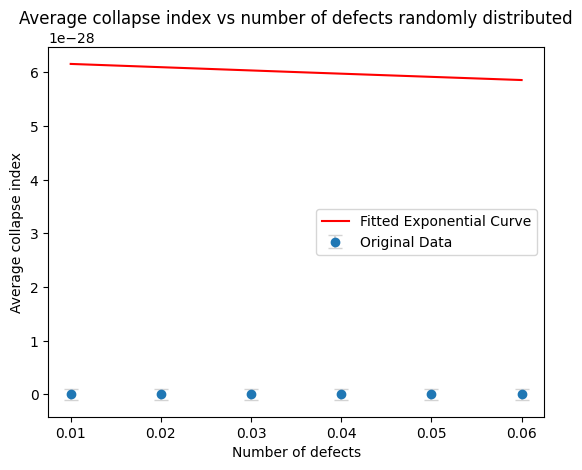

In [42]:
from scipy.optimize import curve_fit


# Define the exponential function
def exp_decay_func(x, a, b):
    return a * np.exp(-b * x)


densities = np.array(densities)
# Perform the curve fitting
params, _ = curve_fit(exp_decay_func, densities, collapse_points)
a, b = params[0], params[1]

# Generate a denser set of x-values for the smoother curve
x_dense = np.linspace(densities.min(), densities.max(), 500)

# Calculate the fitted y-values for the denser x-values
fitted_y_dense = exp_decay_func(x_dense, a, b)

# Calculate residuals and the standard deviation
residuals = collapse_points - exp_decay_func(densities, a, b)
std_dev = np.std(residuals)

# Create the plot
plt.errorbar(densities, collapse_points, yerr=std_dev, fmt="o", label="Original Data", ecolor="lightgray", capsize=5)
plt.plot(x_dense, fitted_y_dense, label="Fitted Exponential Curve", color="red")

# Add labels, title, and legend
plt.xlabel("Number of defects")
plt.ylabel("Average collapse index")
plt.title("Average collapse index vs number of defects randomly distributed")
plt.legend()

create_dirpath("results/experiment3c/defector_collapse_index_v_defect_num.png")
plt.savefig("results/experiment3c/defector_collapse_index_v_defect_num.png")

# Show the plot
plt.show()

In [37]:
print(collapse_points)

[1. 1. 1. 1. 1. 1.]


# Testing animations
create an gif of a grid of credits evolving

In [ ]:
grid_size = 50
num_rounds = 10
CHOSEN_PAYOFF_MATRIX = TYPICAL_PAYOFF_MATRIX

iterations = 1

sets, players_switchers = assign_switchers(grid_size, len(pool_of_switchers))

init_credit = 0  # initial credit per player

for k in range(iterations):
    s = Simulator(grid_size, grid_size, pm=CHOSEN_PAYOFF_MATRIX)
    s.init_network("Lattice")
    s.init_grid()
    for i in range(grid_size):
        for j in range(grid_size):
            chosen_strategy = random.choice([AlwaysCooperateStrategy, AlwaysDefectStrategy])
            # chosen_switcher = pool_of_switchers[players_switchers[(i,j)]]
            chosen_switcher = NOPSwitcher
            s.set_player(i, j, Player(chosen_strategy(), chosen_switcher(), init_credit))

    credit_matrices = s.simulate(n_rounds=num_rounds, ask_credits=True)

In [ ]:
from matplotlib.animation import FuncAnimation

# Example data: a simple 3D numpy array
# For the sake of example, let's create a 3D array with random data
np.random.seed(0)


# Function to update the plot for each frame
def update(frame):
    mat.set_data(credit_matrices[frame])
    return [mat]


# Set up the initial plot
fig, ax = plt.subplots()
mat = ax.matshow(credit_matrices[0], cmap="viridis")
plt.colorbar(mat)
ax.set_title("Credit matrix evolution")

# Create the animation
ani = FuncAnimation(fig, update, frames=num_rounds, interval=200, blit=True)
create_dirpath("results/animations/credit_matrix_evolution.gif")
ani.save("results/animations/lattice_evolution.gif", writer="pillow", fps=5)

# Tests

## CooperateUntilNDefectionsInARow

In [ ]:
def test_cooperate_until_n_defections_in_a_row(threshold_n, repeated_list):
    print(f"Testing CooperateUntilNDefectionsInARow (N = {threshold_n})")
    s = Simulator(n=2, m=1, pm=TYPICAL_PAYOFF_MATRIX)
    s.init_network("Lattice")
    s.init_grid()
    s.set_player(0, 0, Player(AlwaysCooperateStrategy(), CooperateUntilNDefectionsInARow(threshold_n)))
    s.set_player(1, 0, Player(ListRepeatedStrategy(repeated_list), NOPSwitcher()))

    expected_strategies = []
    threshold_hit, ds_in_a_row = False, 0
    for move in repeated_list:
        assert move in ["C", "D"]

        if move == "D":
            ds_in_a_row += 1
        else:
            ds_in_a_row = 0

        if ds_in_a_row >= threshold_n:
            threshold_hit = True

        if threshold_hit:
            expected_strategies.append(AlwaysDefectStrategy)
        else:
            expected_strategies.append(AlwaysCooperateStrategy)

    if DEBUG:
        print(
            f"Expected strategy for repeated list {repeated_list}: {[expected_strategy.__name__ for expected_strategy in expected_strategies]}"
        )

    assert s.grid[0][0].strategy.__class__ == AlwaysCooperateStrategy

    for expected_strategy in expected_strategies:
        s.simulate(n_rounds=1)
        assert s.grid[0][0].strategy.__class__ == expected_strategy

In [ ]:
test_cooperate_until_n_defections_in_a_row(
    threshold_n=1,
    repeated_list=["D"],
)

In [ ]:
test_cooperate_until_n_defections_in_a_row(
    threshold_n=1,
    repeated_list=["C", "C", "D", "D", "C", "D"],
)

In [ ]:
test_cooperate_until_n_defections_in_a_row(
    threshold_n=2,
    repeated_list=["C", "C", "D", "D", "C", "D"],
)

In [ ]:
test_cooperate_until_n_defections_in_a_row(
    threshold_n=3,
    repeated_list=["C", "C", "D", "D", "C", "D"],
)

## TitForTat

In [ ]:
def test_tit_for_tat(repeated_list):
    print(f"Testing TitForTat")
    s = Simulator(n=2, m=1, pm=TYPICAL_PAYOFF_MATRIX)
    s.init_network("Lattice")
    s.init_grid()
    s.set_player(0, 0, Player(AlwaysCooperateStrategy(), TitForTat()))
    s.set_player(1, 0, Player(ListRepeatedStrategy(repeated_list), NOPSwitcher()))

    expected_strategies = []
    for move in repeated_list:
        assert move in ["C", "D"]

        if move == "D":
            expected_strategies.append(AlwaysDefectStrategy)
        else:
            expected_strategies.append(AlwaysCooperateStrategy)

    if DEBUG:
        print(
            f"Expected strategy for repeated list {repeated_list}: {[expected_strategy.__name__ for expected_strategy in expected_strategies]}"
        )

    assert s.grid[0][0].strategy.__class__ == AlwaysCooperateStrategy

    for expected_strategy in expected_strategies:
        s.simulate(n_rounds=1)
        assert s.grid[0][0].strategy.__class__ == expected_strategy

In [ ]:
test_tit_for_tat(
    repeated_list=["C", "C", "D", "D", "C", "D", "C", "C", "D", "D"]
)

## RetaliateWithTwoDefections

In [ ]:
def test_retaliate_with_two_defections(repeated_list, *, n_retaliations=2):
    print(f"Testing RetaliateWithTwoDefections")
    s = Simulator(n=2, m=1, pm=TYPICAL_PAYOFF_MATRIX)
    s.init_network("Lattice")
    s.init_grid()
    s.set_player(0, 0, Player(AlwaysCooperateStrategy(), RetaliateWithTwoDefections()))
    s.set_player(1, 0, Player(ListRepeatedStrategy(repeated_list), NOPSwitcher()))

    expected_strategies = []
    n_defections_left = 0
    for move in repeated_list:
        assert n_defections_left >= 0
        assert move in ["C", "D"]

        if move == "D":
            n_defections_left += n_retaliations

        if n_defections_left > 0:
            n_defections_left -= 1
            expected_strategies.append(AlwaysDefectStrategy)
        else:
            expected_strategies.append(AlwaysCooperateStrategy)

    if DEBUG:
        print(
            f"Expected strategy for repeated list {repeated_list}: {[expected_strategy.__name__ for expected_strategy in expected_strategies]}"
        )

    assert s.grid[0][0].strategy.__class__ == AlwaysCooperateStrategy

    for expected_strategy in expected_strategies:
        s.simulate(n_rounds=1)
        assert s.grid[0][0].strategy.__class__ == expected_strategy

In [ ]:
test_retaliate_with_two_defections(
    repeated_list=["C", "C", "D", "C", "C", "C", "C"]
)

In [ ]:
test_retaliate_with_two_defections(
    repeated_list=["C", "D", "D", "C", "C", "C", "C"]
)

In [ ]:
test_retaliate_with_two_defections(
    repeated_list=["C", "C", "D", "D", "C", "D", "C", "C", "D", "D"]
)

## SoftMajor

## AdaptiveSwitcher